In [1]:
import numpy as np
import pandas as pd
from pandas import read_csv
import matplotlib.pyplot as plt
import pickle
import os

In [2]:
from postcode.decoding_functions import *
from postcode.spot_detection_functions import *
from postcode.reading_data_functions import *

In [3]:
%load_ext autoreload
%autoreload 2

* Specify directory location 'data_path' with channel_info.csv, taglist.csv, tile_names.csv and selected_tiles directory with registered tif files

In [4]:
dataset_name = 'NT_ISS_KR0018'
data_path = '/Users/mg617/data/'+ dataset_name + '/' 

## Spot detection

* Read channel_info.csv and taglist.csv files

In [5]:
barcodes_01, K, R, C, gene_names, channels_info = read_taglist_and_channel_info(data_path)

* Specify input parameters for loading tiles and for spot detection

In [6]:
tifs_path = data_path + 'selected_tiles/'
tile_names = read_csv(data_path + 'tile_names.csv')
tile_names = tile_names.drop_duplicates(subset=['selected_tile_names'])
tiles_info = {'tile_size':1000, 'y_max':16, 'x_max':23, 'y_max_size':1000, 'x_max_size':1000, 'filename_prefix':'out_opt_flow_registered_'}
tiles_to_load = {'y_start':3, 'y_end':4, 'x_start':19, 'x_end':20} # select which tiles to load, including indices at the end
#tiles_to_load = {'y_start':0, 'y_end':tiles_info['y_max']-1, 'x_start':10, 'x_end':tiles_info['x_max']} # all possible tiles
spots_params = {'trackpy_spot_diam':5} # parameters for spot detection: spot diameter has to be specified
spots_params['trackpy_prc'] = 0 #by default this parameter is set to 64, decrease it to select more spots
spots_params['trackpy_sep'] = 2 #by default this paramerer is set to 'trackpy_diam_detect'+1

* Load tile by tile and extract spots in each tile using trackpy or load already extracted spots from directory data_path + 'decoding/extracted-spots/' 

In [7]:
load_already_extracted = True
if load_already_extracted:
    spots = np.load(data_path + 'decoding/extracted-spots/' + dataset_name + '_spots_trackpy_0_sep2.npy')
    spots_loc = read_csv(data_path + 'decoding/extracted-spots/' + dataset_name + '_spots_trackpy_0_sep2_locations.csv')
else:   
    spots, spots_loc, spots_notophat = load_tiles_to_extract_spots(tifs_path, channels_info, C, R, tile_names, tiles_info, tiles_to_load, spots_params, 
                                                                   anchors_cy_ind_for_spot_detect=0,
                                                                   compute_also_without_tophat=True)

In [8]:
print('In total {} spots were detected.'.format(spots.shape[0]))

In total 394498 spots were detected.


## Spot decoding

* Estimate model parameters and compute class probabilities

In [9]:
out = decoding_function(spots, barcodes_01, print_training_progress=True)

100%|██████████| 257/257 [00:06<00:00, 39.83it/s]


* Create a data frame from the decoding output

In [10]:
df_class_names = np.concatenate((gene_names,['infeasible','background','nan']))
df_class_codes = np.concatenate((channels_info['barcodes_AGCT'],['inf','0000','NA']))
decoded_spots_df = decoding_output_to_dataframe(out, df_class_names, df_class_codes)
decoded_df = pd.concat([decoded_spots_df, spots_loc], axis=1) 

In [11]:
# ## save dataframe with decoded spots
# decoded_df.to_csv(data_path + 'decoding/' + dataset_name + '_PoSTcode.csv', index=False)

## Visualizing decoding results

* Plot loss, estimated activation parameters and covariance: loss should decrease, alpha+beta shoud be separated from alpha, covariance matrix should have a checkerboard pattern

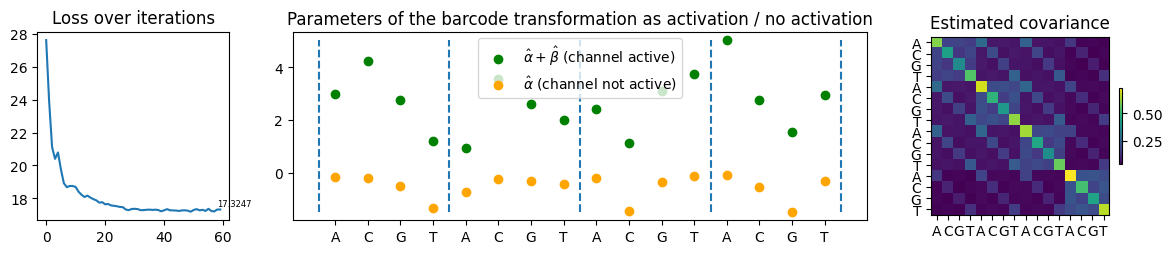

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, gridspec_kw={'width_ratios': [1, 3, 1]}, figsize=(14, 2.5), dpi=100, facecolor='w', edgecolor='k')
activation = (out['params']['codes_tr_v_star']+out['params']['codes_tr_consts_v_star'])[0,:].numpy() #corresponding to the channel activation (code=1)
no_activation = out['params']['codes_tr_consts_v_star'][0,:].numpy() # (code=0)
channel_activation=np.stack((no_activation,activation))
ax1.plot(np.arange(0,len(out['params']['losses'])),(1/out['class_probs'].shape[0]*np.asarray(out['params']['losses'])))
ax1.annotate(np.round(1/out['class_probs'].shape[0]*out['params']['losses'][-1],4),(-2+len(out['params']['losses']),0.2+1/out['class_probs'].shape[0]*out['params']['losses'][-1]),size=6)
ax1.set_title('Loss over iterations')
ax2.scatter(np.arange(1,1+R*C),activation,c='green',label=r'$\hat{\alpha}+\hat{\beta}$ (channel active)') 
ax2.scatter(np.arange(1,1+R*C),no_activation,c='orange',label=r'$\hat{\alpha}$ (channel not active)') 
ax2.legend(loc=9)
ax2.vlines(np.arange(0.5,R*C+.8,C), out['params']['codes_tr_consts_v_star'].min(), (out['params']['codes_tr_v_star']+out['params']['codes_tr_consts_v_star']).max(), linestyles='dashed')
ax2.set_xticks(np.arange(1,1+R*C))
ax2.set_xticklabels(np.tile(np.array(channels_info['channel_base'])[np.where(np.array(channels_info['coding_chs']) == True)[0]],R))
ax2.set_title('Parameters of the barcode transformation as activation / no activation')
covim = ax3.imshow(out['params']['sigma_star'])
ax3.set_xticks(np.arange(0,R*C))
ax3.set_xticklabels(np.tile(np.array(channels_info['channel_base'])[np.where(np.array(channels_info['coding_chs']) == True)[0]],R))
ax3.set_yticks(np.arange(0,R*C))
ax3.set_yticklabels(np.tile(np.array(channels_info['channel_base'])[np.where(np.array(channels_info['coding_chs']) == True)[0]],R))
ax3.set_title('Estimated covariance')
plt.colorbar(covim, ax=ax3, fraction=0.02)
#plt.savefig(os.getcwd() + '/out_imgs/' + dataset_name +'_params.png')
plt.show()

* Plot a histogram of barcode assignments

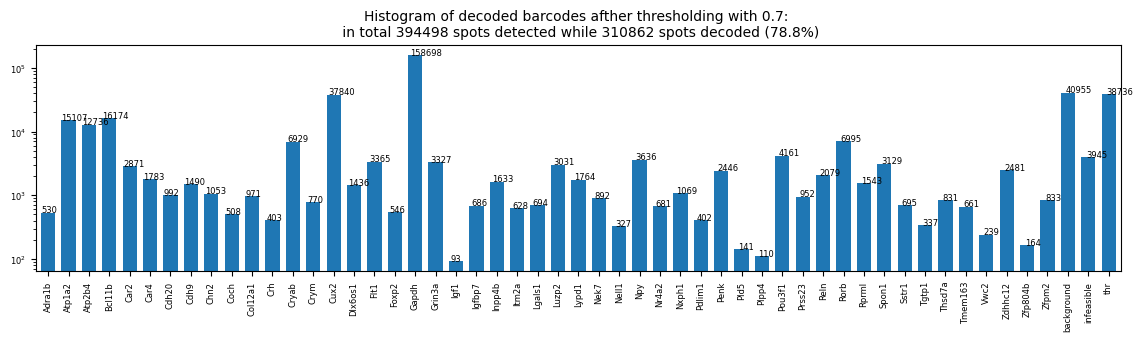

In [13]:
thr=0.7
df = pd.concat([decoded_df.Name[decoded_df.Probability>thr].value_counts(), decoded_df.Name[decoded_df.Probability <=thr].replace(np.unique(decoded_df.Name),'thr').value_counts()]).sort_index(axis=0)#.sort_values(ascending=False)
fig, ax = plt.subplots(1, 1, figsize=(14,3), dpi=100, facecolor='w', edgecolor='k')
df.plot(kind='bar',width=0.7,rot=90,logy=True,fontsize=6,ax=ax)
num_decoded_barcodes = sum((decoded_df.Name!='background')&(decoded_df.Name!='infeasible')&(decoded_df.Name!='NaN')&(decoded_df.Probability>thr))
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005),size=6) 
plt.title('Histogram of decoded barcodes afther thresholding with {}: \n in total {} spots detected while {} spots decoded ({}%)'.format(thr,decoded_df.shape[0], num_decoded_barcodes , np.round(100*num_decoded_barcodes/ decoded_df.shape[0], 2 )),fontsize=10)       
#plt.savefig(os.getcwd() + '/out_imgs/' + dataset_name +'_histogram.png')
plt.show()

* Plot spatial patterns 

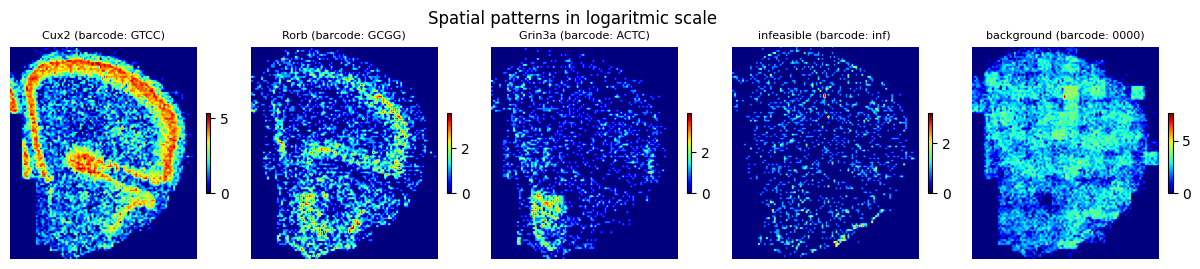

In [14]:
names = ['Cux2','Rorb','Grin3a','infeasible','background']
log_scale = True
fig, ax = plt.subplots(1, len(names), figsize=(3*len(names), 3), dpi=100, facecolor='w', edgecolor='k')
for i in range(len(names)):
    im = heatmap_pattern(decoded_df, names[i], grid=150, thr=0.7, plot_probs=True)
    if log_scale:
        ims = ax[i].imshow(np.log2(1+im),cmap='jet')
    else:
        ims = ax[i].imshow(im)
    ax[i].axis('off')
    plt.colorbar(ims, ax=ax[i], fraction=0.02)
    ax[i].set_title('{} (barcode: {})'.format(names[i],df_class_codes[df_class_names==names[i]][0]),fontsize=8)
#plt.savefig(os.getcwd() + '/out_imgs/' + dataset_name + '_decoded_' + name +'.png')
fig.suptitle('Spatial patterns in logaritmic scale')
plt.show()

## Comparison with argmax and k-means decoding 
'data_path' should have decoding results computed by different methods computed in matlab

In [15]:
#decoded_df = read_csv(data_path + 'decoding/' + dataset_name + '_PoSTcode.csv')
decoded_df_argmax = read_csv(data_path + 'decoding/' + dataset_name + '_argmax.csv')
decoded_df_kmeans = read_csv(data_path + 'decoding/' + dataset_name + '_kmeans.csv')

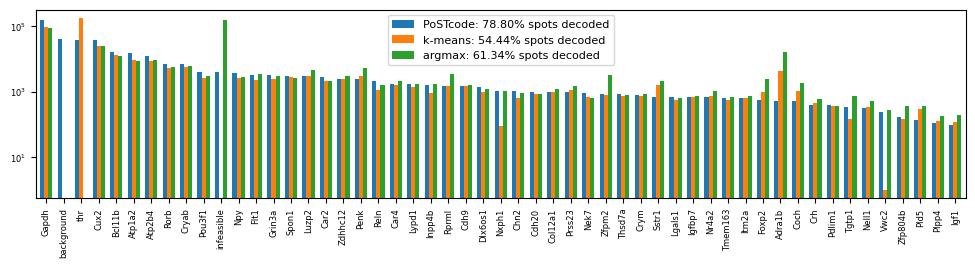

In [16]:
df = pd.concat([decoded_df.Name[decoded_df.Probability>0.7].value_counts(), decoded_df.Name[decoded_df.Probability <=0.7].replace(np.unique(decoded_df.Name),'thr').value_counts()]).sort_index(axis=0)
df_kmeans = pd.concat([decoded_df_kmeans.Name[decoded_df_kmeans.Score>0.9].value_counts(), decoded_df_kmeans.Name[decoded_df_kmeans.Score <=0.9].replace(np.unique(decoded_df_kmeans.Name),'thr').value_counts()]).sort_index(axis=0)
df_argmax = decoded_df_argmax.Name.value_counts()
df_together= pd.DataFrame(columns=['PoSTcode', 'k-means','argmax'],index=df.index)
df_together['PoSTcode']=df
df_together['k-means']=df_kmeans
df_together['argmax']=df_argmax
df_together=df_together.fillna(0)
df_together=df_together.sort_values(by='PoSTcode', ascending=False)
fig, ax = plt.subplots(1, 1, figsize=(12,2.5), dpi=100, facecolor='w', edgecolor='k')
df_together.plot(kind='bar',width=0.7,rot=90,logy=True,fontsize=6,ax=ax)
ax.legend(["PoSTcode: {:.02f}% spots decoded".format(100*sum((decoded_df.Name!='background')&(decoded_df.Name!='infeasible')&(decoded_df.Name!='NaN')&(decoded_df.Probability>0.7))/decoded_df.shape[0]),
           "k-means: {:.02f}% spots decoded".format(100*sum(decoded_df_kmeans.Score>0.9)/decoded_df_kmeans.shape[0]),
           "argmax: {:.02f}% spots decoded".format(100*sum(decoded_df_argmax.Name!='infeasible')/decoded_df_argmax.shape[0])],fontsize=8,loc=9)        
plt.show()

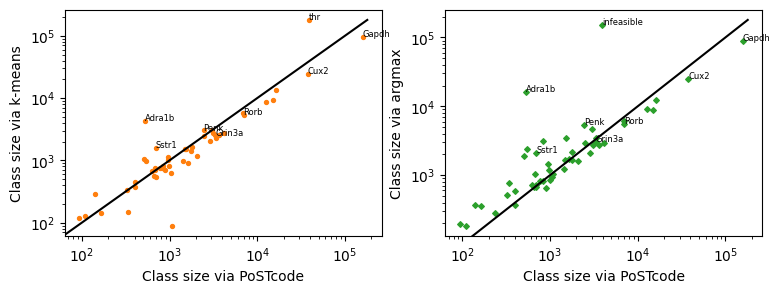

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,3), dpi=100, facecolor='w', edgecolor='k')
x = np.linspace(0, df_together.max().max())
ax1.scatter(df_together['PoSTcode'][df_together['k-means']>1],df_together['k-means'][df_together['k-means']>1], 8, color='tab:orange')
ax1.plot(x, x, '-k',)
ax1.set_xlabel('Class size via PoSTcode')
ax1.set_ylabel('Class size via k-means')
ax1.set_xscale('log')
ax1.set_yscale('log')
for k in list(df_together.index[df_together['k-means']>1]):
    if k in ['thr', 'Penk', 'Adra1b', 'Sstr1', 'Cux2', 'Rorb', 'Grin3a', 'Gapdh']:
        ax1.annotate(k, (df_together['PoSTcode'][df_together['k-means']>1][k],df_together['k-means'][df_together['k-means']>1][k]), fontsize=6)
ax2.scatter(df_together['PoSTcode'][df_together['argmax']>1],df_together['argmax'][df_together['argmax']>1], 8, marker='D',color='tab:green')
ax2.plot(x, x, '-k',)
ax2.set_xlabel('Class size via PoSTcode')
ax2.set_ylabel('Class size via argmax')
ax2.set_xscale('log')
ax2.set_yscale('log')
for k in list(df_together.index[df_together['argmax']>1]):
    if k in ['infeasible', 'Penk', 'Adra1b', 'Sstr1', 'Cux2', 'Rorb', 'Grin3a', 'Gapdh']:
        ax2.annotate(k, (df_together['PoSTcode'][df_together['argmax']>1][k],df_together['argmax'][df_together['argmax']>1][k]), fontsize=6)
plt.show()

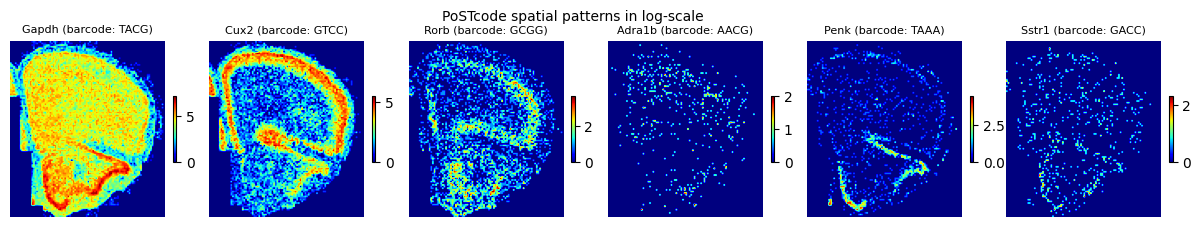

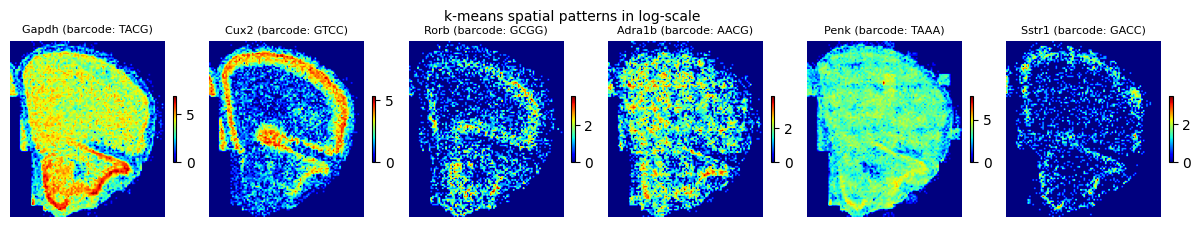

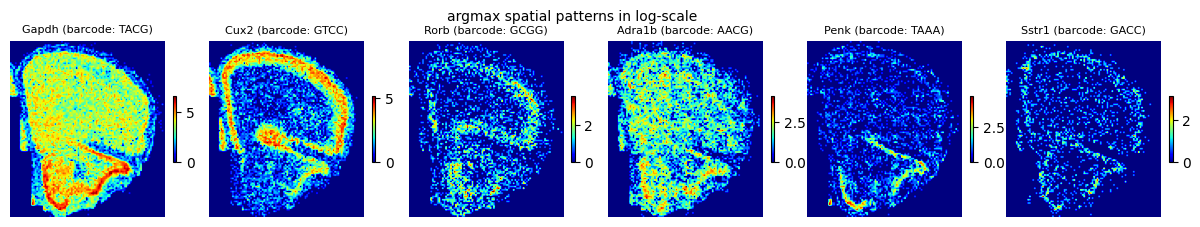

In [18]:
names = ['Gapdh','Cux2','Rorb','Adra1b','Penk','Sstr1']
log_scale = True
fig, ax = plt.subplots(1, len(names), figsize=(2.5*len(names), 2.5), dpi=100, facecolor='w', edgecolor='k')
for i in range(len(names)):
    im = heatmap_pattern(decoded_df, names[i], grid=150, thr=0.7, plot_probs=False)
    if log_scale:
        ims = ax[i].imshow(np.log2(1+im),cmap='jet')
    else:
        ims = ax[i].imshow(im)
    ax[i].axis('off')
    plt.colorbar(ims, ax=ax[i], fraction=0.02)
    ax[i].set_title('{} (barcode: {})'.format(names[i],df_class_codes[df_class_names==names[i]][0]),fontsize=8)
fig.suptitle('PoSTcode spatial patterns{}'.format(' in log-scale'*log_scale),fontsize=10)
plt.show()
fig, ax = plt.subplots(1, len(names), figsize=(2.5*len(names), 2.5), dpi=100, facecolor='w', edgecolor='k')
for i in range(len(names)):
    im = heatmap_pattern(decoded_df_kmeans, names[i], grid=150, thr=0.7, plot_probs=False)
    if log_scale:
        ims = ax[i].imshow(np.log2(1+im),cmap='jet')
    else:
        ims = ax[i].imshow(im)
    ax[i].axis('off')
    plt.colorbar(ims, ax=ax[i], fraction=0.02)
    ax[i].set_title('{} (barcode: {})'.format(names[i],df_class_codes[df_class_names==names[i]][0]),fontsize=8)
fig.suptitle('k-means spatial patterns{}'.format(' in log-scale'*log_scale),fontsize=10)
plt.show()
fig, ax = plt.subplots(1, len(names), figsize=(2.5*len(names), 2.5), dpi=100, facecolor='w', edgecolor='k')
for i in range(len(names)):
    im = heatmap_pattern(decoded_df_argmax, names[i], grid=150, thr=0.7, plot_probs=False)
    if log_scale:
        ims = ax[i].imshow(np.log2(1+im),cmap='jet')
    else:
        ims = ax[i].imshow(im)
    ax[i].axis('off')
    plt.colorbar(ims, ax=ax[i], fraction=0.02)
    ax[i].set_title('{} (barcode: {})'.format(names[i],df_class_codes[df_class_names==names[i]][0]),fontsize=8)
fig.suptitle('argmax spatial patterns{}'.format(' in log-scale'*log_scale),fontsize=10)
plt.show()

In [19]:
decoded_df_0 = read_csv(data_path + 'decoding/' + dataset_name + '_PoSTcode.csv')

In [20]:
df = pd.concat([decoded_df.Name[decoded_df.Probability>0.7].value_counts(), decoded_df.Name[decoded_df.Probability <=0.7].replace(np.unique(decoded_df.Name),'thr').value_counts()]).sort_index(axis=0)
df0 = pd.concat([decoded_df_0.Name[decoded_df_0.Probability>0.7].value_counts(), decoded_df_0.Name[decoded_df_0.Probability <=0.7].replace(np.unique(decoded_df_0.Name),'thr').value_counts()]).sort_index(axis=0)
df_together= pd.DataFrame(columns=['PoSTcode', '0'],index=df.index)
df_together['PoSTcode']=df
df_together['0']=df0

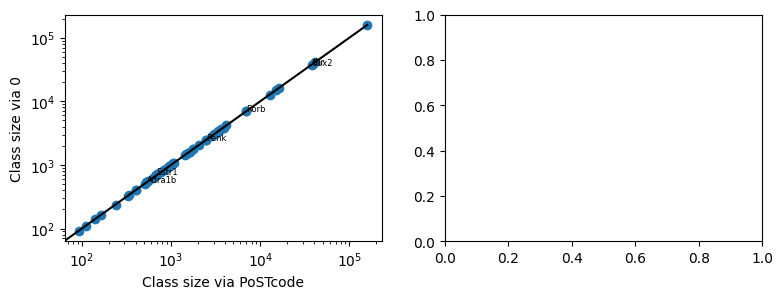

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,3), dpi=100, facecolor='w', edgecolor='k')
x = np.linspace(0, df_together.max().max())
ax1.scatter(df_together['PoSTcode'][df_together['0']>1],df_together['0'][df_together['0']>1])
ax1.plot(x, x, '-k',)
ax1.set_xlabel('Class size via PoSTcode')
ax1.set_ylabel('Class size via 0')
ax1.set_xscale('log')
ax1.set_yscale('log')
for k in list(df_together.index[df_together['0']>1]):
    if k in ['thr', 'Penk', 'Adra1b', 'Sstr1', 'Cux2', 'Rorb']:
        ax1.annotate(k, (df_together['PoSTcode'][df_together['0']>1][k],df_together['0'][df_together['0']>1][k]), fontsize=6)


In [22]:
df - df0

Adra1b         -9
Atp1a2        137
Atp2b4          7
Bcl11b        -54
Car2           22
Car4           -2
Cdh20          -2
Cdh9           -9
Chn2           -1
Coch            8
Col12a1         9
Crh             2
Cryab         -60
Crym           -1
Cux2          189
Dlx6os1         4
Flt1          -29
Foxp2          -8
Gapdh         -39
Grin3a         -3
Igf1            1
Igfbp7         -1
Inpp4b         13
Itm2a          -3
Lgals1          6
Luzp2         -20
Lypd1         -11
Nek7           -1
Nell1          -3
Npy            -7
Nr4a2         -15
Nxph1          -7
Pdlim1          2
Penk           -9
Pld5            2
Plpp4          -1
Pou3f1        -58
Prss23          5
Reln           20
Rorb            8
Rprml          -2
Spon1          26
Sstr1         -24
Tgtp1           0
Thsd7a         -4
Tmem163        -5
Vwc2            2
Zdhhc12        -2
Zfp804b         1
Zfpm2           2
background   -437
infeasible    157
thr           204
Name: Name, dtype: int64